In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

from bokeh.io import show, output_notebook
from bokeh.plotting import figure, gridplot
from bokeh.models import LinearAxis, Range1d
output_notebook()

Loading BokehJS ...

### GPU
指定使用的 GPU 编号。  
`watch -n 1 nvidia-smi` 实时查看 GPU 的运行状态。 

In [2]:
torch.cuda.set_device("cuda:3")
torch.cuda.current_device()
# device = torch.device("cuda:5")
# xxx.to(device)

3

### Data
通过`torchvision.datasets`下载`MNIST`数据。  
训练集：`train=True`  
测试集：`train=False`  
常用的还有`torchvision.datasets.ImageFolder()`，按文件夹取图片。  

`torchvision.transforms`可以对图片做处理。  
`trans` 对两种处理进行了组合，包括化为`Tensor`、归一化。

In [3]:
trans = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

In [4]:
train_dataset = dsets.MNIST(root='../dataset', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = dsets.MNIST(root='../dataset', train=False, transform=transforms.ToTensor(), download=True)

batch_size = 100
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=True)

### Model
分别定义生成器 G 和判别器 D，两者进行博弈。

In [5]:
class GAN(nn.Module):
    def __init__(self):
        super().__init__()
        self.G = nn.Sequential(
            nn.Linear(64, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 784),
            nn.Tanh()
        )
        self.D = nn.Sequential(
            nn.Linear(784, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    def forward(self, z):
        return self.G(z)
    def score(self, z):
        fake_imgs = self.G(z)
        fake_score = self.D(fake_imgs)
        return fake_score

In [6]:
lrate = 0.0003
epochs = 200

model = GAN().cuda()
criterion = nn.BCELoss()
optim_G = torch.optim.Adam(model.G.parameters(), lr = lrate)
optim_D = torch.optim.Adam(model.D.parameters(), lr = lrate)
model

GAN(
  (G): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=256, out_features=784, bias=True)
    (5): Tanh()
  )
  (D): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=256, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

在训练过程中，每经过 300 个 batch 就检验 选中的 5 个图像的生成情况。

In [7]:
def list_img(i, img, title):
    img = img.reshape(28, 28)
    plt.subplot(2, 5, i+1)
    plt.imshow(img)
    plt.title('%s' % (title))
    
def generate_test(inputs, title=''):
    plt.figure(figsize=(15, 6))
    imgs = model(inputs)
    imgs = (imgs + 1) / 2
    imgs.clamp(0, 1)
    for i in range(len(inputs)):
        list_img(i, imgs[i].cpu().detach().numpy(), title)
    plt.show()

注意：每次反向传播的时候都需要将参数的梯度归零。  
`optim.step()`则在每个`Variable`的`grad`都被计算出来后，更新每个`Variable`的数值

在每次训练中都用`train_loader`中的一个`batch`作为训练数据。  
`Tensor.cuda()` 每个 `batch` 在实际使用之前，都先移入 `GPU` 后进行计算。  

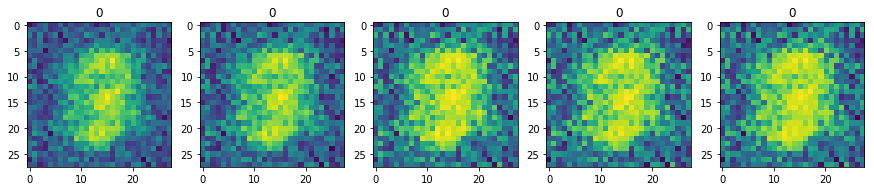

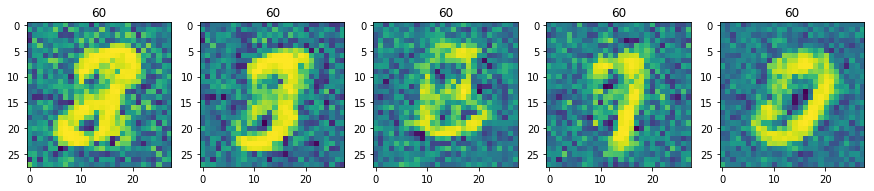

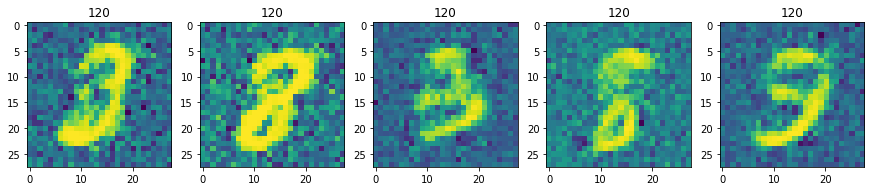

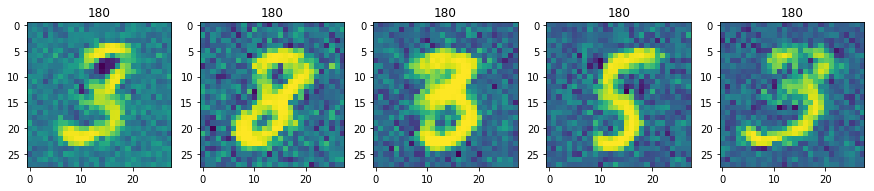

In [8]:
result_d = []
result_g = []
test_inputs = torch.randn(5, 64).cuda()

for e in range(epochs):
    for i, (inputs, _) in enumerate(train_loader):
        inputs = inputs.view(-1, 28*28).cuda()
        real_labels = torch.ones(batch_size, 1).cuda()
        fake_labels = torch.zeros(batch_size, 1).cuda()
        
        # Train D   loss(D(real_img), real) + loss(D(fake_img), fake)
        real_score = model.D(inputs)
        loss_d_real = criterion(real_score, real_labels)
        
        fake_score = model.score(torch.randn(batch_size, 64).cuda())
        loss_d_fake = criterion(fake_score, fake_labels)
        
        optim_D.zero_grad() 
        loss_d = loss_d_real + loss_d_fake
        loss_d.backward()
        optim_D.step()
        
        # Train G  loss(D(G(z)), real)
        fake_score = model.score(torch.randn(batch_size, 64).cuda())
        loss_g = criterion(fake_score, real_labels)
        
        optim_G.zero_grad()
        loss_g.backward()
        optim_G.step()
        
        # Check generation
        if i % 100 == 0:
            result_d.append(float(loss_d))
            result_g.append(float(loss_g))
    if e % 60 == 0:
        generate_test(test_inputs, str(e))
fig = figure()
fig.line(range(len(result_d)), result_d, legend='D loss', line_width=1.5)
fig.line(range(len(result_g)), result_g, legend='G loss', line_color="green")
show(fig)

### Result
由上图可见图像的生成趋向于清晰。

分别导入真实图片和生成图片，查看判别器的效果。  
判别器可以识别出大部分的真实图片是真实的，也能识别出所有生成图片是生成的。  
因此判别器效果很好，而生成器效果很差。

In [9]:
for i, (img, _) in enumerate(test_loader):
    if i > 9: break
    img = img.view(-1, 28*28).cuda()
    real_score = model.D(img.squeeze())
    print(real_score)

tensor([0.3235], device='cuda:3', grad_fn=<SigmoidBackward>)
tensor([1.], device='cuda:3', grad_fn=<SigmoidBackward>)
tensor([0.0041], device='cuda:3', grad_fn=<SigmoidBackward>)
tensor([1.], device='cuda:3', grad_fn=<SigmoidBackward>)
tensor([1.], device='cuda:3', grad_fn=<SigmoidBackward>)
tensor([1.], device='cuda:3', grad_fn=<SigmoidBackward>)
tensor([1.], device='cuda:3', grad_fn=<SigmoidBackward>)
tensor([1.], device='cuda:3', grad_fn=<SigmoidBackward>)
tensor([1.], device='cuda:3', grad_fn=<SigmoidBackward>)
tensor([0.9569], device='cuda:3', grad_fn=<SigmoidBackward>)


In [10]:
fake_score = model.score(torch.randn(10, 64).cuda())
print(fake_score)

tensor([[1.3863e-01],
        [1.8132e-04],
        [1.5209e-03],
        [3.6482e-02],
        [7.8784e-04],
        [6.9412e-05],
        [6.1832e-03],
        [6.0682e-03],
        [1.6882e-02],
        [4.2760e-02]], device='cuda:3', grad_fn=<SigmoidBackward>)


### Save Model

In [11]:
torch.save(model.state_dict(), 'gan-cuda.pkl')

### Related Models

- [WGAN](https://zhuanlan.zhihu.com/p/25071913)
- InfoGAN